In [1]:
import scipy
import scipy.sparse
import numpy as np
import glob
# import caiman as cm
# from caiman.utils import visualization
import os
from os.path import join, exists
import pandas as pd


from scipy.stats import zscore

from brainiak.eventseg.event import EventSegment
import matplotlib.patches as patches
import bisect

import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

from scipy.stats import wasserstein_distance, pearsonr
import brainiak.eventseg.event as event

In [2]:
#set paths
data_path = '/Users/f004p4z/Documents/Analysis_post_caiman/Filtering_cells/Filtered_cells/Modified'
file_water_1 = 'DS2_water_day1_aligned_filtered.csv'
file_water_2 = 'DS2_water_day2_aligned_filtered.csv'
file_sucrose_1 = 'DS2_sucrose_day1_aligned_filtered.csv'
file_sucrose_2 = 'DS2_sucrose_day2_aligned_filtered.csv'


In [3]:
complete_water_1_name = os.path.join(data_path, file_water_1)
complete_water_2_name = os.path.join(data_path, file_water_2)
complete_sucrose_1_name = os.path.join(data_path, file_sucrose_1)
complete_sucrose_2_name = os.path.join(data_path, file_sucrose_2)


print(complete_water_1_name)
print(complete_water_2_name)
print(complete_sucrose_1_name)
print(complete_sucrose_2_name)

/Users/f004p4z/Documents/Analysis_post_caiman/Filtering_cells/Filtered_cells/Modified/DS2_water_day1_aligned_filtered.csv
/Users/f004p4z/Documents/Analysis_post_caiman/Filtering_cells/Filtered_cells/Modified/DS2_water_day2_aligned_filtered.csv
/Users/f004p4z/Documents/Analysis_post_caiman/Filtering_cells/Filtered_cells/Modified/DS2_sucrose_day1_aligned_filtered.csv
/Users/f004p4z/Documents/Analysis_post_caiman/Filtering_cells/Filtered_cells/Modified/DS2_sucrose_day2_aligned_filtered.csv


In [4]:
water_1 = pd.read_csv(complete_water_1_name, low_memory=False)
water_2 = pd.read_csv(complete_water_2_name, low_memory=False)
sucrose_1 = pd.read_csv(complete_sucrose_1_name, low_memory=False)
sucrose_2 = pd.read_csv(complete_sucrose_2_name, low_memory=False)


In [5]:
def z_score(file):
    # Drop first column
    file.drop(columns=file.columns[0], axis=1, inplace=True)
    
    #z-score
    z_scored_file = file.iloc[:,1:-11].apply(zscore)
    # add time column
    z_scored_file['time']=file['time']
    #make time the first column
    first_column = z_scored_file.pop('time')
    z_scored_file.insert(0, 'time', first_column)
    return z_scored_file


In [6]:
z_scored_water1 = z_score(water_1)
z_scored_water2 = z_score(water_2)
z_scored_sucrose1 = z_score(sucrose_1)
z_scored_sucrose2 = z_score(sucrose_2)


In [7]:
z_scored_water1

,time,8,13,15,16,19,20,21,22,23,...,162,164,166,169,170,171,172,173,176,177
0,0.00,4.467956,8.000928,5.279355,-0.670598,-0.517325,-0.703586,-0.149964,-0.766744,-0.443149,...,1.308285,9.962775,2.926011,5.606106,-0.406060,-0.681156,-0.413922,2.789013,3.061252,0.587772
1,0.05,4.593699,7.313782,4.881134,-0.670598,-0.517325,-0.703586,-0.217204,-0.766744,-0.443149,...,1.641890,9.597190,2.759707,5.515077,-0.406060,-0.696204,-0.413922,2.431213,2.569607,0.976447
2,0.10,4.187074,7.535407,4.509921,-0.670598,-0.517325,-0.703586,-0.278946,-0.766744,-0.443149,...,1.399728,8.932726,2.341036,4.959127,-0.406060,-0.709919,-0.413922,2.105533,2.146047,2.209397
3,0.15,3.812878,6.885758,4.163882,-0.327472,-0.517325,-0.703586,-0.147352,-0.766744,-0.443149,...,1.180489,7.925417,3.441484,4.453137,-0.091734,-0.722420,-0.413922,1.809091,1.781141,3.382856
4,0.20,3.468524,6.412627,3.841312,-0.351979,-0.517325,-0.703586,-0.214805,-0.766744,-0.443149,...,0.982004,8.831570,2.936660,5.213383,2.198860,-0.733814,-0.413922,1.539261,1.466769,4.472428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48059,2402.95,0.314833,-0.363362,-0.589661,-0.048038,-0.214393,0.150947,0.694892,-0.192612,-0.442672,...,-0.317991,-0.339404,-0.343280,-0.619314,-0.405332,-0.028800,0.040853,-1.042656,-0.271725,-0.512002
48060,2403.00,0.249452,-0.376781,-0.589852,-0.092502,-0.245490,0.940919,0.809263,-0.241689,-0.442720,...,-0.374630,-0.361197,-0.369844,-0.624015,-0.405410,-0.101607,-0.022768,-1.056476,-0.301812,-0.527600
48061,2403.05,0.189286,-0.389120,-0.590030,-0.133791,-0.273395,1.049629,0.663593,0.075023,-0.442763,...,-0.425908,-0.380674,-0.393052,-0.628293,-0.405480,-0.167968,-0.077488,-1.069055,-0.327733,-0.541586
48062,2403.10,0.133918,-0.400464,-0.590196,-0.172131,-0.298436,0.932731,0.529834,0.003069,-0.442802,...,-0.472332,-0.398080,-0.413326,-0.632187,-0.405543,-0.228453,-0.124554,-0.668787,-0.350064,-0.554125


mean:  4.292159948679431
standard deviation:  7.334193744231805
min:  0.5885750086289608
max:  218.76648064354785


<AxesSubplot:title={'center':'Trace_cell 13, z-scored'}, xlabel='time'>

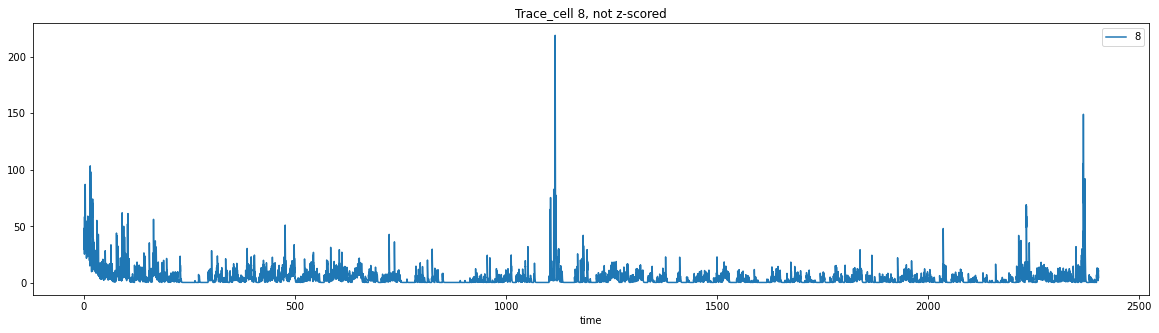

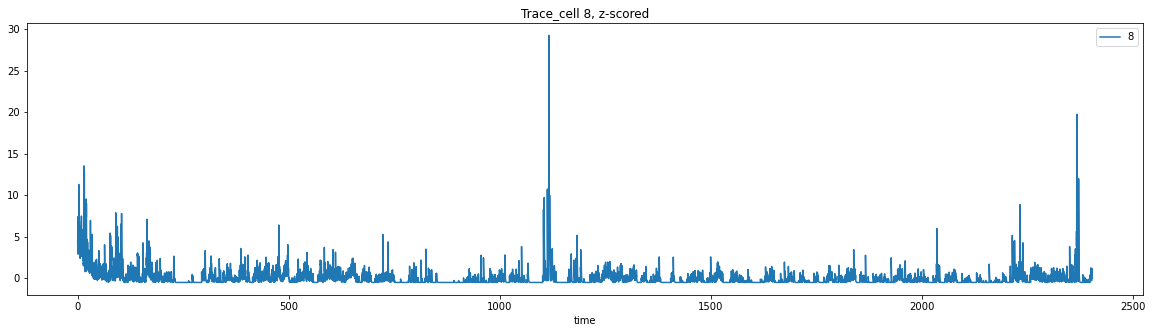

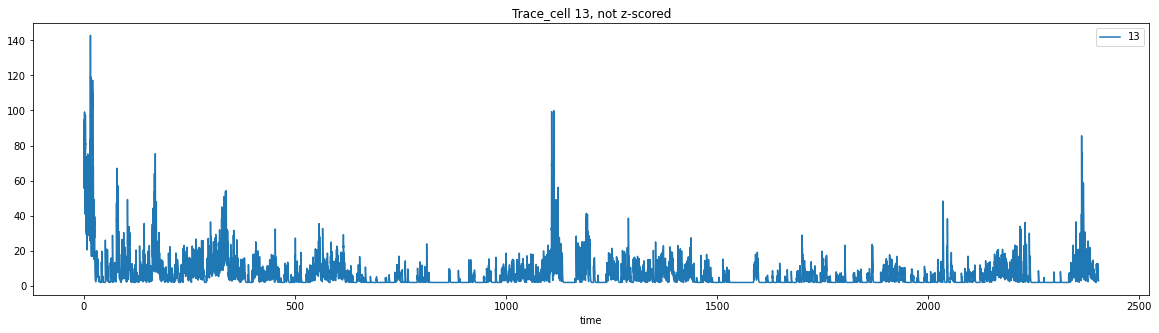

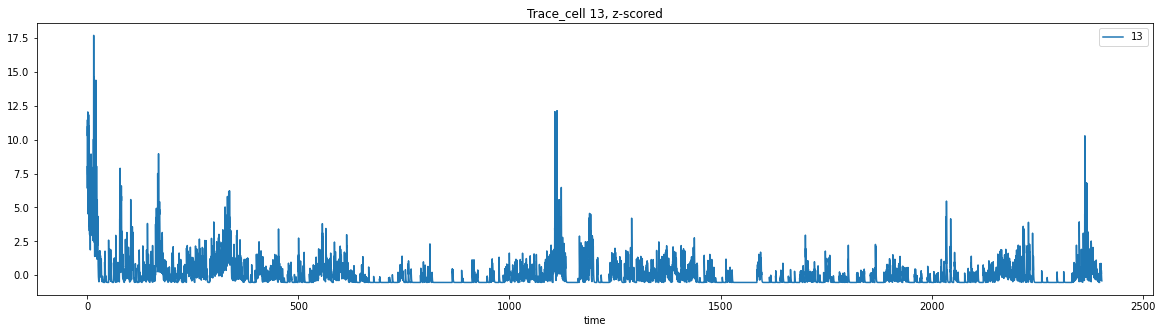

In [8]:
#sanity check- did the z-scoring work correctly?
print('mean: ',np.mean(water_1['8']))
print('standard deviation: ', np.std(water_1['8']))
print('min: ', np.min(water_1['8']))
print('max: ', np.max(water_1['8']))

water_1.plot(x="time", y="8", title='Trace_cell 8, not z-scored',figsize=(20,5))

z_scored_water1.plot(x="time", y="8", title='Trace_cell 8, z-scored',figsize=(20,5))

water_1.plot(x="time", y="13", title='Trace_cell 13, not z-scored',figsize=(20,5))

z_scored_water1.plot(x="time", y="13", title='Trace_cell 13, z-scored',figsize=(20,5))


In [9]:
def conv_numpy(file):
    z_scored_file_np =np.transpose(file).to_numpy()
    return z_scored_file_np

In [10]:
# convert to numpy
z_scored_water1_np = conv_numpy(z_scored_water1)
z_scored_water2_np = conv_numpy(z_scored_water2)
z_scored_sucrose1_np = conv_numpy(z_scored_sucrose1)
z_scored_sucrose2_np = conv_numpy(z_scored_sucrose2)

In [11]:
# check that there are no na/values
array_list =[z_scored_water1_np, z_scored_water2_np, z_scored_sucrose1_np,z_scored_sucrose2_np]
na_list = []
for item in array_list: 
    array_sum = np.sum(item)
    array_has_nan = np.isnan(array_sum)
    na_list.append(array_has_nan)

if ('True' in na_list):
    print('There is at least one n/a value in one of the arrays, review the arrays before proceeding')
else:
    print("There are no n/a values in any of the arrays, please proceed to the next step")

There are no n/a values in any of the arrays, please proceed to the next step


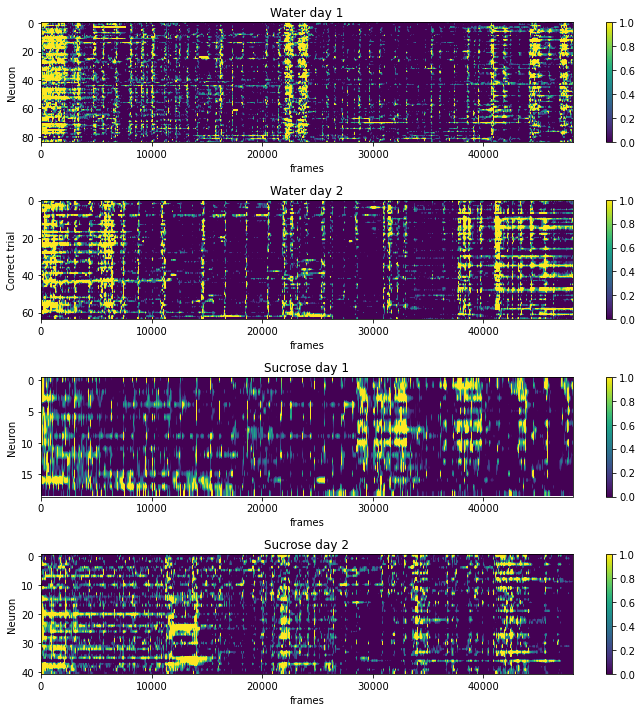

In [12]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(10, 10), nrows=4)
#fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(10, 8))

im1 = ax1.imshow(z_scored_water1_np[1:], vmin=0, vmax=1, aspect='auto')
ax1.set_title('Water day 1')
ax1.set_xlabel('frames')
ax1.set_ylabel('Neuron')
fig.colorbar(im1, ax=ax1, location='right', anchor=(0, 0.3))


im2 = ax2.imshow(z_scored_water2_np[1:],  vmin=0, vmax=1, aspect='auto')
ax2.set_title('Water day 2')
ax2.set_xlabel('frames')
ax2.set_ylabel('Correct trial')
fig.colorbar(im2, ax=ax2, location='right', anchor=(0, 0.3))


im3 = ax3.imshow(z_scored_sucrose1_np[1:],  vmin=0, vmax=1, aspect='auto')
ax3.set_title('Sucrose day 1')
ax3.set_xlabel('frames')
ax3.set_ylabel('Neuron')
fig.colorbar(im3, ax=ax3, location='right', anchor=(0, 0.3))


im4 = ax4.imshow(z_scored_sucrose2_np[1:], vmin=0, vmax=1, aspect='auto')
ax4.set_title('Sucrose day 2')
ax4.set_xlabel('frames')
ax4.set_ylabel('Neuron')
fig.colorbar(im4, ax=ax4, location='right', anchor=(0, 0.3))
fig.tight_layout()

plt.show()

In [13]:
def get_array_event(dataframe, z_scored_array, event, frames_before, frames_after):
    
    """Get a 3D array that has the activity of all cells a certain time before and after a specific event
     Args:
         dataframe:       pandas.core.frame.DataFrame
                          dataframe that has the cell activity + behavior information for one session 
         z_scored_array:  numpy.ndarray
                          an array that contains only the time + neural data 
         event:           string
                          name of the event type that you want to align 
         frames_before:   int
                          number of frames you want to extract prior to the aligned event
         frames_after:    int
                          number of frames you want to extract after the aligned event
    Returns:
         event_array:     np.ndarray
                          a 3D array that has all of the cells aligned to a specific event, with data included
                          frames before and after 
    """
    # get all the indices when the event occurs 
    event_index = []
    index = -1
    for item in dataframe[event]:
        index +=1
        if item ==1:
            event_index.append(index)
    
    # make a for loop to get all the trials of the specific event 
    event_array = np.empty((len(event_index), z_scored_array.shape[0],frames_before+frames_after))
    for i in range(len(event_index)-1):
        event_trial = z_scored_array[:,event_index[i]-frames_before:event_index[i]+frames_after]
        event_array[i]= event_trial
    
    return event_array



In [14]:
corr_trial_water1 = get_array_event(water_1, z_scored_water1_np, 'correct_trial', 80, 80)
corr_trial_water2 = get_array_event(water_2, z_scored_water2_np, 'correct_trial', 80, 80)
corr_trial_sucrose1 = get_array_event(sucrose_1, z_scored_sucrose1_np, 'correct_trial', 80, 80)
corr_trial_sucrose2 = get_array_event(sucrose_2, z_scored_sucrose2_np, 'correct_trial', 80, 80)


In [15]:
# check that there are no na/values
array_list =[corr_trial_water1, corr_trial_water2, corr_trial_sucrose1,corr_trial_sucrose2]
na_list = []
for item in array_list: 
    array_sum = np.sum(item)
    array_has_nan = np.isnan(array_sum)
    na_list.append(array_has_nan)
print(na_list)
if ('True' in na_list):
    print('There is at least one n/a value in one of the arrays, review the arrays before proceeding')
else:
    print("There are no n/a values in any of the arrays, please proceed to the next step")

[False, False, False, False]
There are no n/a values in any of the arrays, please proceed to the next step


In [16]:
corr_trial_water1.shape

(20, 85, 160)

In [17]:
print(len(corr_trial_water1))
print(len(corr_trial_water2))
print(len(corr_trial_sucrose1))
print(len(corr_trial_sucrose2))

20
11
35
35


In [18]:
corr_trial_water1[0][1:].shape

(84, 160)

In [19]:
type(corr_trial_water1)


numpy.ndarray

In [20]:
# !pip install tqdm

In [21]:
def create_diag_mask(arr, diag_start=0, diag_limit=None):
    diag_mask = np.zeros_like(arr, dtype=bool)
    if diag_limit is None:
        diag_limit = find_diag_limit(arr)

    for k in range(diag_start, diag_limit):
        ix = kth_diag_indices(diag_mask, k)
        diag_mask[ix] = True

    return diag_mask

In [22]:
def find_diag_limit(arr):
    for k in range(arr.shape[0]):
        d = np.diag(arr, k=k)
        if ~(d > 0).any():
            return k

In [23]:
def kth_diag_indices(arr, k):
    row_ix, col_ix = np.diag_indices_from(arr)
    if k == 0:
        return row_ix, col_ix
    else:
        return row_ix[:-k], col_ix[k:]


In [26]:
# wd from scratch - cleaned up version- works, DO NOT CHANGE
n_events = np.arange(2, 160)
wd = np.zeros(len(n_events))
corrmat = np.corrcoef(np.transpose(corr_trial_water1[0][1:]))

for i, events in enumerate(n_events):
    ev = event.EventSegment(events)
    ev.fit(np.transpose(corr_trial_water1[0][1:]))
    i1, i2 = np.where(np.round(ev.segments_[0]) == 1)

    w = np.zeros_like(ev.segments_[0])
    w[i1, i2] = 1
    mask = np.dot(w, w.T).astype(bool)

    local_mask = create_diag_mask(mask)

    within_vals = np.reshape(corrmat[mask*local_mask],(-1))
    across_vals = np.reshape(corrmat[~mask*local_mask], (-1))

    wd[i] = wasserstein_distance(within_vals, across_vals)


In [28]:
def wass_dist():

    # neural_data: format (timepoints, cells) 
    # wd from scratch - 
    
    n_events = np.arange(2, 160)
    wd = np.zeros(len(n_events))
    corrmat = np.corrcoef(np.transpose(corr_trial_water1[0][1:]))

    for i, events in enumerate(n_events):
        ev = event.EventSegment(events)
        ev.fit(np.transpose(corr_trial_water1[0][1:]))
        i1, i2 = np.where(np.round(ev.segments_[0]) == 1)

        w = np.zeros_like(ev.segments_[0])
        w[i1, i2] = 1
        mask = np.dot(w, w.T).astype(bool)

        local_mask = create_diag_mask(mask)

        within_vals = np.reshape(corrmat[mask*local_mask],(-1))
        across_vals = np.reshape(corrmat[~mask*local_mask], (-1))

        wd[i] = wasserstein_distance(within_vals, across_vals)

        return n_events, wd
        


In [78]:

neural_data = np.transpose(corr_trial_water1[9][1:])


In [29]:
n_events,wd = wass_dist()

In [60]:
neural_data.shape

(160, 84)

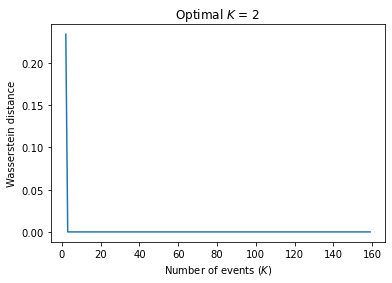

In [30]:
# 0th correct trial
plt.plot(n_events, wd)
maxk_video = n_events[np.argmax(wd)]
plt.ylabel('Wasserstein distance')
plt.xlabel('Number of events ($K$)')
plt.title(f'Optimal $K$ = {maxk_video}')
# plt.savefig(FIG_DIR.joinpath('k_optimization_video.pdf'), bbox_inches='tight')
plt.show()


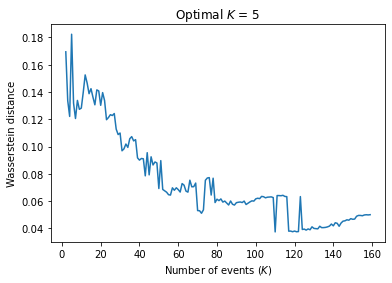

In [53]:
# 0th correct trial
plt.plot(n_events, wd)
maxk_video = n_events[np.argmax(wd)]
plt.ylabel('Wasserstein distance')
plt.xlabel('Number of events ($K$)')
plt.title(f'Optimal $K$ = {maxk_video}')
# plt.savefig(FIG_DIR.joinpath('k_optimization_video.pdf'), bbox_inches='tight')
plt.show()


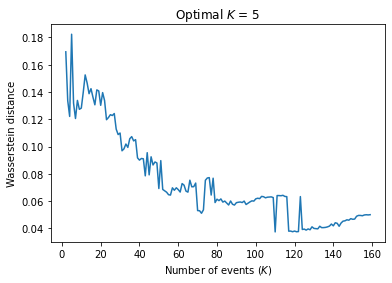

In [54]:
# 9th correct trial
plt.plot(n_events, wd)
maxk_video = n_events[np.argmax(wd)]
plt.ylabel('Wasserstein distance')
plt.xlabel('Number of events ($K$)')
plt.title(f'Optimal $K$ = {maxk_video}')
# plt.savefig(FIG_DIR.joinpath('k_optimization_video.pdf'), bbox_inches='tight')
plt.show()


In [ ]:
# wd from scratch - cleaned up version- works, DO NOT CHANGE
n_events = np.arange(2, 160)
wd = np.zeros(len(n_events))
corrmat = np.corrcoef(np.transpose(corr_trial_water1[9][1:]))

for i, events in enumerate(n_events):
    ev = event.EventSegment(events)
    ev.fit(np.transpose(corr_trial_water1[0][1:]))
    i1, i2 = np.where(np.round(ev.segments_[0]) == 1)

    w = np.zeros_like(ev.segments_[0])
    w[i1, i2] = 1
    mask = np.dot(w, w.T).astype(bool)

    local_mask = create_diag_mask(mask)

    within_vals = np.reshape(corrmat[mask*local_mask],(-1))
    across_vals = np.reshape(corrmat[~mask*local_mask], (-1))

    wd[i] = wasserstein_distance(within_vals, across_vals)


In [ ]:
# wd from scratch - works DO NOT EDIT
n_events = np.arange(2, 160)
wd = np.zeros(len(n_events))
corrmat = np.corrcoef(np.transpose(corr_trial_water1[9][1:]))

######################################################
# many thanks to Chris Baldassano for his suggestion #
# of a non-parametric K-optimization approach        #
######################################################
for i, events in enumerate(n_events):
    ev = event.EventSegment(events)
    ev.fit(np.transpose(corr_trial_water1[0][1:]))
#     print(ev.segments_[0][1])
    i1, i2 = np.where(np.round(ev.segments_[0]) == 1)
#     print('i1 shape:',i1.shape)
#     print('i2 shape:',i2.shape)
#     segments_
#     number-of-timepoints by number-of-events matrix whose entries describe the probability of each timepoint
#     belonging to each event (i.e., the probability of being in each state at a given timepoint).

    
    w = np.zeros_like(ev.segments_[0])
#     print(w)
#     print(w.shape)
#     print('ssssss')
    w[i1, i2] = 1
#     
#     print('w shape:', w.shape)

    mask = np.dot(w, w.T).astype(bool)
#     print('mask shape:',mask.shape)

    # Create mask such that the maximum temporal distance 
    # for within and across correlations is the same
    local_mask = create_diag_mask(mask)
    
#     print('local mask shape:',local_mask.shape)
#     s = corrmat[mask*local_mask]
#     print(s)
  

    within_vals = np.reshape(corrmat[mask*local_mask],(-1))
#     print('within_vals shape: ',within_vals.shape)
    across_vals = np.reshape(corrmat[~mask*local_mask], (-1))
#     print('across_vals shape: ', across_vals.shape)
    
    
# alternate    
#     within_vals = np.ndarray.flatten(corrmat[mask*local_mask]) 
#     print('within_vals shape: ',within_vals.shape)
#     across_vals = np.ndarray.flatten(corrmat[~mask*local_mask])
# #     print('across_vals shape: ', across_vals.shape)
    wd[i] = wasserstein_distance(within_vals, across_vals)
# #     print('wasserstein_distance: ', wd)


In [111]:
def wass_HMM(numpy_array, trial_number):
    timepoints = numpy_array[1:].shape[2]
    n_events = np.arange(2, timepoints)
    wd = np.zeros(len(n_events))
    corrmat = np.corrcoef(np.transpose(numpy_array[trial_number]))

    ######################################################
    # many thanks to Chris Baldassano for his suggestion #
    # of a non-parametric K-optimization approach        #
    ######################################################
    for i, events in enumerate(n_events):
        ev = event.EventSegment(events)
        ev.fit(np.transpose(numpy_array[trial_number][1:]))
    #     print(ev.segments_[0][1])
        i1, i2 = np.where(np.round(ev.segments_[0]) == 1)
    #     print('i1 shape:',i1.shape)
    #     print('i2 shape:',i2.shape)
    #     segments_
    #     number-of-timepoints by number-of-events matrix whose entries describe the probability of each timepoint
    #     belonging to each event (i.e., the probability of being in each state at a given timepoint).


        w = np.zeros_like(ev.segments_[0])
    #     print(w)
    #     print(w.shape)
    #     print('ssssss')
        w[i1, i2] = 1
    #     
    #     print('w shape:', w.shape)

        mask = np.dot(w, w.T).astype(bool)
    #     print('mask shape:',mask.shape)

        # Create mask such that the maximum temporal distance 
        # for within and across correlations is the same
        local_mask = create_diag_mask(mask)

    #     print('local mask shape:',local_mask.shape)
    #     s = corrmat[mask*local_mask]
    #     print(s)


        within_vals = np.reshape(corrmat[mask*local_mask], (-1)) 
        print('within_vals shape: ',within_vals.shape)
        across_vals = np.reshape(corrmat[~mask*local_mask], (-1))
        print('across_vals shape: ', across_vals.shape)



#         within_vals = np.ndarray.flatten(corrmat[mask*local_mask]) 
#     #     print('within_vals shape: ',within_vals.shape)
#         across_vals = np.ndarray.flatten(corrmat[~mask*local_mask])
#     #     print('across_vals shape: ', across_vals.shape)
#         wd[i] = wasserstein_distance(within_vals, across_vals)
        
        return n_events, wd
    #     print('wasserstein_distance: ', wd)
    
    


In [36]:
n_events, wd = wass_HMM(corr_trial_water1, 0)

within_vals shape:  (0,)
across_vals shape:  (0,)


within_vals shape:  (0,)
across_vals shape:  (0,)
within_vals shape:  (3856,)
across_vals shape:  (2323,)


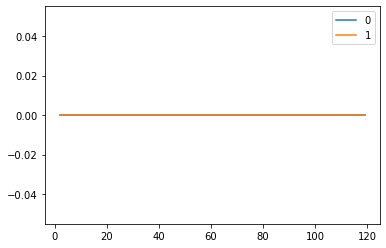

In [29]:
#trials = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
trials = [0,1]
for trial in trials:
    n_events, wd = wass_HMM(corr_trial_water1, trial)
    plt.plot(n_events, wd, label = trial)
    plt.legend()
    

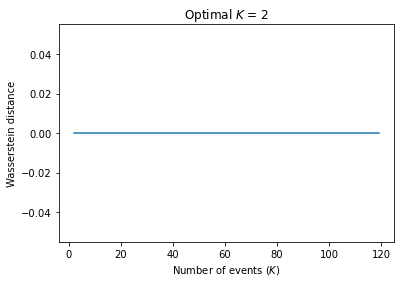

In [30]:
plt.plot(n_events, wd)
maxk_video = n_events[np.argmax(wd)]
plt.ylabel('Wasserstein distance')
plt.xlabel('Number of events ($K$)')
plt.title(f'Optimal $K$ = {maxk_video}')
# plt.savefig(FIG_DIR.joinpath('k_optimization_video.pdf'), bbox_inches='tight')
plt.show()


## Code Graveyard

In [ ]:
#works 
# wd from scratch
n_events = np.arange(2, 7)
wd = np.zeros(len(n_events))
corrmat = np.corrcoef(np.transpose(corr_trial_water1[0][1:]))

######################################################
# many thanks to Chris Baldassano for his suggestion #
# of a non-parametric K-optimization approach        #
######################################################
for i, events in enumerate(n_events):
    ev = event.EventSegment(events)
    ev.fit(np.transpose(corr_trial_water1[0][1:]))
#     print(ev.segments_[0][1])
    i1, i2 = np.where(np.round(ev.segments_[0]) == 1)
#     print('i1 shape:',i1.shape)
#     print('i2 shape:',i2.shape)
#     segments_
#     number-of-timepoints by number-of-events matrix whose entries describe the probability of each timepoint
#     belonging to each event (i.e., the probability of being in each state at a given timepoint).

    
    w = np.zeros_like(ev.segments_[0])
#     print(w)
#     print(w.shape)
#     print('ssssss')
    w[i1, i2] = 1
#     
#     print('w shape:', w.shape)

    mask = np.dot(w, w.T).astype(bool)
#     print('mask shape:',mask.shape)

    # Create mask such that the maximum temporal distance 
    # for within and across correlations is the same
    local_mask = create_diag_mask(mask)
    
#     print('local mask shape:',local_mask.shape)
#     s = corrmat[mask*local_mask]
#     print(s)
  

    within_vals = np.reshape(corrmat[mask*local_mask],(-1))
    print('within_vals shape: ',within_vals.shape)
    across_vals = np.reshape(corrmat[~mask*local_mask], (-1))
#     print('across_vals shape: ', across_vals.shape)
    
    
# alternate    
#     within_vals = np.ndarray.flatten(corrmat[mask*local_mask]) 
#     print('within_vals shape: ',within_vals.shape)
#     across_vals = np.ndarray.flatten(corrmat[~mask*local_mask])
# #     print('across_vals shape: ', across_vals.shape)
    wd[i] = wasserstein_distance(within_vals, across_vals)
# #     print('wasserstein_distance: ', wd)


In [ ]:
# works 
def wass_HMM(numpy_array, trial_number):
    timepoints = numpy_array[1:].shape[2]
    n_events = np.arange(2, timepoints)
    wd = np.zeros(len(n_events))
    corrmat = np.corrcoef(np.transpose(numpy_array[trial_number]))

    ######################################################
    # many thanks to Chris Baldassano for his suggestion #
    # of a non-parametric K-optimization approach        #
    ######################################################
    for i, events in enumerate(n_events):
        ev = event.EventSegment(events)
        ev.fit(np.transpose(numpy_array[trial_number][1:]))
    #     print(ev.segments_[0][1])
        i1, i2 = np.where(np.round(ev.segments_[0]) == 1)
    #     print('i1 shape:',i1.shape)
    #     print('i2 shape:',i2.shape)
    #     segments_
    #     number-of-timepoints by number-of-events matrix whose entries describe the probability of each timepoint
    #     belonging to each event (i.e., the probability of being in each state at a given timepoint).


        w = np.zeros_like(ev.segments_[0])
    #     print(w)
    #     print(w.shape)
    #     print('ssssss')
        w[i1, i2] = 1
    #     
    #     print('w shape:', w.shape)

        mask = np.dot(w, w.T).astype(bool)
    #     print('mask shape:',mask.shape)

        # Create mask such that the maximum temporal distance 
        # for within and across correlations is the same
        local_mask = create_diag_mask(mask)

    #     print('local mask shape:',local_mask.shape)
    #     s = corrmat[mask*local_mask]
    #     print(s)


        within_vals = np.reshape(corrmat[mask*local_mask], (-1)) 
        print('within_vals shape: ',within_vals.shape)
        across_vals = np.reshape(corrmat[~mask*local_mask], (-1))
        print('across_vals shape: ', across_vals.shape)



#         within_vals = np.ndarray.flatten(corrmat[mask*local_mask]) 
#     #     print('within_vals shape: ',within_vals.shape)
#         across_vals = np.ndarray.flatten(corrmat[~mask*local_mask])
#     #     print('across_vals shape: ', across_vals.shape)
#         wd[i] = wasserstein_distance(within_vals, across_vals)
        
        return n_events, wd
    #     print('wasserstein_distance: ', wd)
    
    


In [98]:
n_events = np.arange(2, 160)
wd = np.zeros(len(n_events))
corrmat = np.corrcoef(np.transpose(corr_trial_water1[9]))

######################################################
# many thanks to Chris Baldassano for his suggestion #
# of a non-parametric K-optimization approach        #
######################################################
for i, events in enumerate(n_events):
    ev = event.EventSegment(events)
#     print(corr_trial_water1[0][1:].shape)
    ev.fit(np.transpose(corr_trial_water1[0][1:]))
#     print(ev.segments_[0][1])
    print(ev.segments_)
    i1, i2 = np.where(np.round(ev.segments_[0]) == 1)
#     print('i1 shape:',i1.shape)
#     print('i2 shape:',i2.shape)
#     segments_
#     number-of-timepoints by number-of-events matrix whose entries describe the probability of each timepoint
#     belonging to each event (i.e., the probability of being in each state at a given timepoint).

    
    w = np.zeros_like(ev.segments_[0])
#     print(w)
#     print(w.shape)
#     print('ssssss')
    w[i1, i2] = 1
#     
#     print('w shape:', w.shape)

    mask = np.dot(w, w.T).astype(bool)
#     print('mask shape:',mask.shape)

    # Create mask such that the maximum temporal distance 
    # for within and across correlations is the same
    local_mask = create_diag_mask(mask)
    
#     print('local mask shape:',local_mask.shape)
#     s = corrmat[mask*local_mask]
#     print(s)
  

#     within_vals = np.reshape(corrmat[mask*local_mask], (-1, 1)) 
#     print('within_vals shape: ',within_vals.shape)
#     across_vals = np.reshape(corrmat[~mask*local_mask], (-1, 1))
#     print('across_vals shape: ', across_vals.shape)
    
    
    
    within_vals = np.ndarray.flatten(corrmat[mask*local_mask]) 
#     print(within_vals)
#     print('within_vals shape: ',within_vals.shape)
    across_vals = np.ndarray.flatten(corrmat[~mask*local_mask])
#     print('across_vals shape: ', across_vals.shape)
    wd[i] = wasserstein_distance(within_vals, across_vals)
#     print('wasserstein_distance: ', wd)


[array([[nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan

ValueError: Distribution can't be empty.

In [99]:
n_events = np.arange(2, 160)
wd = np.zeros(len(n_events))
corrmat = np.corrcoef(np.transpose(corr_trial_water1[9]))

######################################################
# many thanks to Chris Baldassano for his suggestion #
# of a non-parametric K-optimization approach        #
######################################################
for i, events in enumerate(n_events):
    ev = event.EventSegment(events)
    ev.fit(np.transpose(corr_trial_water1[0][1:]))
#     print(ev.segments_[0][1])
    i1, i2 = np.where(np.round(ev.segments_[0]) == 1)
#     print('i1 shape:',i1.shape)
#     print('i2 shape:',i2.shape)
#     segments_
#     number-of-timepoints by number-of-events matrix whose entries describe the probability of each timepoint
#     belonging to each event (i.e., the probability of being in each state at a given timepoint).

    
    w = np.zeros_like(ev.segments_[0])
#     print(w)
#     print(w.shape)
#     print('ssssss')
    w[i1, i2] = 1
#     
#     print('w shape:', w.shape)

    mask = np.dot(w, w.T).astype(bool)
#     print('mask shape:',mask.shape)

    # Create mask such that the maximum temporal distance 
    # for within and across correlations is the same
    local_mask = create_diag_mask(mask)
    
#     print('local mask shape:',local_mask.shape)
#     s = corrmat[mask*local_mask]
#     print(s)
  

#     within_vals = np.reshape(corrmat[mask*local_mask], (-1, 1)) 
#     print('within_vals shape: ',within_vals.shape)
#     across_vals = np.reshape(corrmat[~mask*local_mask], (-1, 1))
#     print('across_vals shape: ', across_vals.shape)
    
    
    
    within_vals = np.ndarray.flatten(corrmat[mask*local_mask]) 
#     print('within_vals shape: ',within_vals.shape)
    across_vals = np.ndarray.flatten(corrmat[~mask*local_mask])
#     print('across_vals shape: ', across_vals.shape)
    wd[i] = wasserstein_distance(within_vals, across_vals)
#     print('wasserstein_distance: ', wd)


ValueError: Distribution can't be empty.

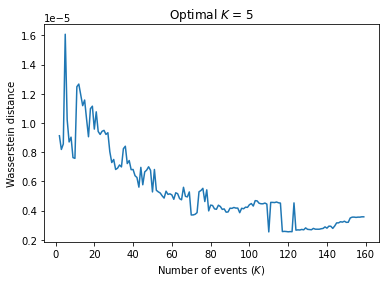

In [333]:
plt.plot(n_events, wd)
maxk_video = n_events[np.argmax(wd)]
plt.ylabel('Wasserstein distance')
plt.xlabel('Number of events ($K$)')
plt.title(f'Optimal $K$ = {maxk_video}')
# plt.savefig(FIG_DIR.joinpath('k_optimization_video.pdf'), bbox_inches='tight')
plt.show()


[[-0.26269898 -0.28202078 -0.29980164 ...  0.12692429  0.07652958
   0.03015393]
 [-0.52946841 -0.52950824 -0.52954486 ... -0.52994268 -0.5299443
  -0.5299458 ]
 [ 0.3938634   0.32697098  0.47688391 ... -0.59224779 -0.59226336
  -0.59227788]
 ...
 [-0.31000084 -0.38959358 -0.46204102 ...  0.60253096  0.44101754
   0.29400359]
 [-0.4785721  -0.48001477 -0.48125767 ... -0.48898972 -0.48898974
  -0.48898976]
 [ 0.92517709  0.7610109   0.61381537 ...  0.81327869  0.66068002
   0.52385616]]


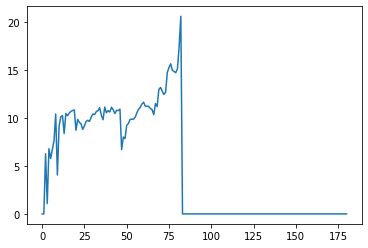

In [207]:
plt.plot(run_HMM(corr_trial_water1))



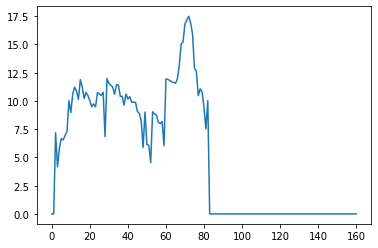

In [ ]:
print(s)
print(r)

In [137]:
run_HMM(corr_trial_water1)


(161,)


In [126]:
run_HMM(corr_trial_water1)


(array([ 2,  5,  9, 12, 15, 18, 22, 24, 27, 29, 35, 37, 39, 41, 43, 49, 53,
       58, 60, 72, 78, 82]),)
[2 5 9]
(1,)
(4,)
(8,)


In [107]:
corr_trial_water1[1:].shape

(19, 85, 160)

In [74]:

timepoints_water1 = corr_trial_water1[1:].shape[2]
GSBS_states_water1 = GSBS(x = corr_trial_water1[0][1:], kmax = timepoints_water1)
GSBS_states_water1.fit()



In [82]:
# extract local maxima


#all the t distances are saved here: GSBS_states_water1.tdists
s =argrelextrema(GSBS_states_water1.tdists, np.greater)
s

(array([ 2,  5,  9, 12, 15, 18, 22, 24, 27, 29, 35, 37, 39, 41, 43, 49, 53,
        58, 60, 72, 78, 82]),)

In [83]:
water1_HMM = EventSegment(n_events = GSBS_states_water1.nstates)
water1_HMM.fit(np.transpose(corr_trial_water1[0][1:]))

EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]),
             n_events=72)

In [87]:
GSBS_states_water1.nstates

72

In [84]:
event_bounds = np.where(np.diff(np.argmax(water1_HMM.segments_[0], axis = 1)))[0]

In [88]:
event_bounds

array([  1,   4,   6,   9,  12,  14,  16,  18,  20,  22,  24,  26,  28,
        30,  33,  35,  38,  41,  43,  46,  48,  50,  53,  54,  57,  59,
        62,  65,  67,  69,  72,  74,  76,  77,  80,  82,  85,  88,  90,
        92,  94,  96,  99, 101, 103, 105, 107, 110, 112, 114, 116, 119,
       120, 122, 124, 126, 128, 130, 132, 134, 135, 137, 139, 142, 144,
       146, 148, 151, 153, 155, 157])

In [81]:
GSBS_states_water1.tdists

array([ 0.        ,  0.        ,  7.18209733,  4.17394761,  5.82027832,
        6.67165052,  6.55227994,  6.94590774,  7.30427514, 10.02860207,
        8.96851604, 10.6042457 , 11.21772191, 10.86707255, 10.13854377,
       11.8860343 , 11.24168498, 10.21335728, 10.75634943, 10.47594163,
       10.03603715,  9.47841835,  9.73901465,  9.46845133, 10.73097512,
       10.60707788, 10.49302543, 10.75211085,  6.83834746, 11.98928517,
       11.57844703, 11.38642773, 11.23125104, 10.5888488 , 11.41738903,
       11.4220525 , 10.40181268, 10.41217356,  9.62047326, 10.60924461,
       10.16953721, 10.37862739,  9.87899892,  9.89659023,  9.87128306,
        9.07997705,  8.89554686,  8.23873897,  5.88109315,  9.01945864,
        6.14031386,  6.08828924,  4.54360382,  9.0361131 ,  8.8470035 ,
        8.76382447,  8.11669373,  7.98608551,  8.18285783,  6.03515698,
       11.93575316, 11.90651044, 11.81257815, 11.69196853, 11.64498232,
       11.55323751, 11.93691986, 13.14235546, 15.04667926, 15.22

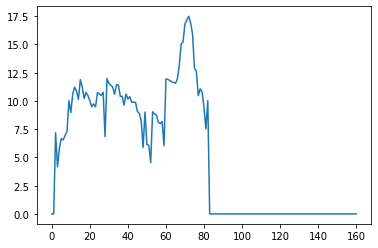

In [80]:
plt.plot(GSBS_states_water1.tdists)

In [ ]:
# first figure out the number of events that are ideal to fit 
from statesegmentation import GSBS
timepoints_water1 = corr_trial_water1[1:].shape[1]
GSBS_states_water1 = GSBS(x = average_corr_trial_water1[1:], kmax = timepoints_water1)
GSBS_states_water1.fit()

# optimal number of state: GSBS_states.nstates
# fit the event segmentation model with this number of states 
water1_HMM = EventSegment(n_events = GSBS_states_water1.nstates)
water1_HMM.fit(np.transpose(average_corr_trial_water1[1:]))

In [ ]:
def plot_tt_similarity_matrix(ax, data_matrix, bounds, timepoints, title_text):
    
    ax.imshow(np.corrcoef(data_matrix), cmap = 'viridis')
    ax.set_title(title_text)
    ax.set_xlabel('timepoint')
    ax.set_ylabel('timepoint')
    
    # plot the boundaries 
    bounds_aug = np.concatenate(([0], bounds, [timepoints]))
    
    for i in range(len(bounds_aug) - 1):
        rect = patches.Rectangle(
            (bounds_aug[i], bounds_aug[i]),
            bounds_aug[i+1] - bounds_aug[i],
            bounds_aug[i+1] - bounds_aug[i],
            linewidth = 2, edgecolor = 'w',facecolor = 'none'
        )
        ax.add_patch(rect)


In [ ]:
def plot_HMM(event_segment_obj, original_matrix, time_points, title_text, GSBS_states, main_title):
    # do some plotting 
    fig, (ax1, ax2) = plt.subplots(2,1)
    fig.suptitle(main_title, fontsize= 'large')

    # set height of each subplot as 8
    fig.set_figheight(15)
    # set width of each subplot as 8
    fig.set_figwidth(15)

    # plot the predicted event boundaries on top of the correlation matrix
    GSBS_bounds = np.where(GSBS_states.get_deltas(2))[0]
    event_bounds = np.where(np.diff(np.argmax(event_segment_obj.segments_[0], axis = 1)))[0]
    plot_tt_similarity_matrix(ax1, np.transpose(original_matrix[1:]), GSBS_bounds, time_points, title_text)

    # plot the figure that shows the optimal number of states
    im2 = ax2.plot(GSBS_states.tdists)
    ax2.set_xlabel('Number of events')
    ax2.set_ylabel('T-distance')
    ax2.set_title('The optimal number of events is ' + str(GSBS_states.nstates))
    ax2.plot(GSBS_states.nstates, GSBS_states.tdists[GSBS_states.nstates], 'ro', label= 'optimal number of events')
    ax2.legend()

    
    fig.tight_layout()
    plt.show()

In [33]:
len(corr_trial_time_water1)

20

In [28]:
# get the correct trial for water1
# water day 1
corr_trial_index_water1 = []
index = -1
for item in water_1['correct_trial']:
    index +=1
    if item ==1:
        corr_trial_index_water1.append(index)

print(len(corr_trial_index_water1))

#water day 2
corr_trial_index_water2 = []
index = -1
for item in water_2['correct_trial']:
    index +=1
    if item ==1:
        corr_trial_index_water2.append(index)

print(len(corr_trial_index_water2))

#sucrose day 1
corr_trial_index_sucrose1 = []
index = -1
for item in sucrose_1['correct_trial']:
    index +=1
    if item ==1:
        corr_trial_index_sucrose1.append(index)

print(len(corr_trial_index_sucrose1))

#sucrose day 2
corr_trial_index_sucrose2 = []
index = -1
for item in sucrose_2['correct_trial']:
    index +=1
    if item ==1:
        corr_trial_index_sucrose2.append(index)

print(len(corr_trial_index_sucrose2))


20
11
35
35


In [14]:
#get the time at the specific indices where there is a correct trial
# water day 1
corr_trial_time_water1 = []
for index in corr_trial_index_water1:
    corr_trial_time_water1.append(water_1['time'][index])
    
# water day 2
corr_trial_time_water2 = []
for index in corr_trial_index_water2:
    corr_trial_time_water2.append(water_2['time'][index])

# sucrose day 1
corr_trial_time_sucrose1 = []
for index in corr_trial_index_sucrose1:
    corr_trial_time_sucrose1.append(sucrose_1['time'][index])

# sucrose day 2
corr_trial_time_sucrose2 = []
for index in corr_trial_index_sucrose2:
    corr_trial_time_sucrose2.append(sucrose_2['time'][index])

In [16]:
len(corr_trial_time_water1)

20

In [15]:
# make a for loop to get all the correct trials
# water1
corr_trial_water1 = np.empty((len(corr_trial_time_water1), z_scored_water1_np.shape[0],120))
for i in range(len(corr_trial_index_water1)-1):
    corr_trial = z_scored_water1_np[:,corr_trial_index_water1[i]-60:corr_trial_index_water1[i]+60]
    corr_trial_water1[i]= corr_trial

# water2
corr_trial_water2 = np.empty((len(corr_trial_time_water2), z_scored_water2_np.shape[0],120))
for i in range(len(corr_trial_index_water2)-1):
    corr_trial = z_scored_water2_np[:,corr_trial_index_water2[i]-60:corr_trial_index_water2[i]+60]
    corr_trial_water2[i]= corr_trial

# sucrose1
corr_trial_sucrose1 = np.empty((len(corr_trial_time_sucrose1), z_scored_sucrose1_np.shape[0],120))
for i in range(len(corr_trial_index_sucrose1)-1):
    corr_trial = z_scored_sucrose1_np[:,corr_trial_index_sucrose1[i]-60:corr_trial_index_sucrose1[i]+60]
    corr_trial_sucrose1[i]= corr_trial

# sucrose2
corr_trial_sucrose2 = np.empty((len(corr_trial_time_sucrose2), z_scored_sucrose2_np.shape[0],120))
for i in range(len(corr_trial_index_sucrose2)-1):
    corr_trial = z_scored_sucrose2_np[:,corr_trial_index_sucrose2[i]-60:corr_trial_index_sucrose2[i]+60]
    corr_trial_sucrose2[i]= corr_trial


In [42]:
col_names_full_water1 = z_scored_water1.columns
col_names_water1=col_names_full_water1


col_names_full_water2 = z_scored_water2.columns
col_names_water2=col_names_full_water2

col_names_full_sucrose1 = z_scored_sucrose1.columns
col_names_sucrose1=col_names_full_sucrose1

col_names_full_sucrose2 = z_scored_sucrose2.columns
col_names_sucrose2=col_names_full_sucrose2

print(len(col_names_water1))
print(len(col_names_water2))
print(len(col_names_sucrose1))
print(len(col_names_sucrose2))



85
65
20
42


In [45]:
def plot_tt_similarity_matrix(ax, data_matrix, bounds, timepoints, title_text):
    
    ax.imshow(np.corrcoef(data_matrix), cmap = 'viridis')
    ax.set_title(title_text)
    ax.set_xlabel('timepoint')
    ax.set_ylabel('timepoint')
    
    # plot the boundaries 
    bounds_aug = np.concatenate(([0], bounds, [timepoints]))
    
    for i in range(len(bounds_aug) - 1):
        rect = patches.Rectangle(
            (bounds_aug[i], bounds_aug[i]),
            bounds_aug[i+1] - bounds_aug[i],
            bounds_aug[i+1] - bounds_aug[i],
            linewidth = 2, edgecolor = 'w',facecolor = 'none'
        )
        ax.add_patch(rect)


In [46]:
def plot_HMM(event_segment_obj, original_matrix, time_points, title_text, GSBS_states, main_title):
    # do some plotting 
    fig, (ax1, ax2) = plt.subplots(2,1)
    fig.suptitle(main_title, fontsize= 'large')

    # set height of each subplot as 8
    fig.set_figheight(15)
    # set width of each subplot as 8
    fig.set_figwidth(15)

    # plot the predicted event boundaries on top of the correlation matrix
    GSBS_bounds = np.where(GSBS_states.get_deltas(2))[0]
    event_bounds = np.where(np.diff(np.argmax(event_segment_obj.segments_[0], axis = 1)))[0]
    plot_tt_similarity_matrix(ax1, np.transpose(original_matrix[1:]), GSBS_bounds, time_points, title_text)

    # plot the figure that shows the optimal number of states
    im2 = ax2.plot(GSBS_states.tdists)
    ax2.set_xlabel('Number of events')
    ax2.set_ylabel('T-distance')
    ax2.set_title('The optimal number of events is ' + str(GSBS_states.nstates))
    ax2.plot(GSBS_states.nstates, GSBS_states.tdists[GSBS_states.nstates], 'ro', label= 'optimal number of events')
    ax2.legend()

    
    fig.tight_layout()
    plt.show()


In [47]:
# def plot_HMM(event_segment_obj, original_matrix, time_points, title_text, GSBS_states, main_title):
#     # do some plotting 
#     fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
#     fig.suptitle(main_title, fontsize= 'large')

#     # set height of each subplot as 8
#     fig.set_figheight(15)
#     # set width of each subplot as 8
#     fig.set_figwidth(15)

#     # first plot the originial correlation matrix
#     im1 = ax1.imshow(np.corrcoef(np.transpose(original_matrix[1:])))
#     ax1.set_title('Pattern correlation')
#     ax1.set_xlabel('Timepoint')
#     ax1.set_ylabel('Timepoint')
#     fig.colorbar(im1, ax=ax1, location='right', anchor=(0, 0))

#     # plot the predicted event boundaries on top of the correlation matrix
#     GSBS_bounds = np.where(GSBS_states.get_deltas(2))[0]
#     event_bounds = np.where(np.diff(np.argmax(event_segment_obj.segments_[0], axis = 1)))[0]
#     plot_tt_similarity_matrix(ax2, np.transpose(original_matrix[1:]), event_bounds, time_points, title_text)

#     # plot the figure that shows the optimal number of states
#     im3 = ax3.plot(GSBS_states.tdists)
#     ax3.set_xlabel('Number of events')
#     ax3.set_ylabel('T-distance')
#     ax3.set_title('The optimal number of events is ' + str(GSBS_states.nstates))
#     ax3.plot(GSBS_states.nstates, GSBS_states.tdists[GSBS_states.nstates], 'ro', label= 'optimal number of events')
#     ax3.legend()

#     # Plot the log-likelihood (measuring overall model fit)
#     im4 = ax4.plot(event_segment_obj.ll_)
#     ax4.set_title('Log likelihood')
#     ax4.set_xlabel('Model fitting steps')

#     fig.tight_layout()
#     plt.show()


In [48]:
# first figure out the number of events that are ideal to fit 
from statesegmentation import GSBS
timepoints_water1 = average_corr_trial_water1[1:].shape[1]
GSBS_states_water1 = GSBS(x = average_corr_trial_water1[1:], kmax = timepoints_water1)
GSBS_states_water1.fit()

# optimal number of state: GSBS_states.nstates
# fit the event segmentation model with this number of states 
water1_HMM = EventSegment(n_events = GSBS_states_water1.nstates)
water1_HMM.fit(np.transpose(average_corr_trial_water1[1:]))

EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
             n_events=81)

In [49]:
average_corr_trial_water2

array([[1068.73671725,  986.14592032, 1068.82954531, ...,  991.31489298,
        1074.21357278,  991.40573481],
       [  87.87386099,    5.09534393,   87.96286719, ...,    5.90946325,
          88.11839887,    5.88809871],
       [  88.304345  ,    5.92115017,   88.24567676, ...,    5.57905685,
          88.38054067,    5.58636239],
       ...,
       [  95.38333904,    5.47733713,   95.49647344, ...,    5.44015621,
          95.37319126,    5.53071595],
       [  95.52057348,    5.59820088,   95.41290188, ...,    5.75117031,
          95.43316278,    5.63762591],
       [  95.81645489,    5.97162471,   95.65622377, ...,    5.42607315,
          95.30531285,    5.33661044]])

In [50]:
# first figure out the number of events that are ideal to fit 
timepoints_water2 = average_corr_trial_water2[1:].shape[1]
GSBS_states_water2 = GSBS(x = average_corr_trial_water2[1:], kmax = timepoints_water2)
GSBS_states_water2.fit()

# optimal number of state: GSBS_states.nstates
# fit the event segmentation model with this number of states 
water2_HMM = EventSegment(n_events = GSBS_states_water2.nstates)
water2_HMM.fit(np.transpose(average_corr_trial_water2[1:]))

EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
             n_events=9)

In [51]:
# first figure out the number of events that are ideal to fit 
timepoints_sucrose1 = average_corr_trial_sucrose1[1:].shape[1]
GSBS_states_sucrose1 = GSBS(x = average_corr_trial_sucrose1[1:], kmax = timepoints_sucrose1)
GSBS_states_sucrose1.fit()

# optimal number of state: GSBS_states.nstates
# fit the event segmentation model with this number of states 
sucrose1_HMM = EventSegment(n_events = GSBS_states_sucrose1.nstates)
sucrose1_HMM.fit(np.transpose(average_corr_trial_sucrose1[1:]))

/Users/f004p4z/opt/anaconda3/envs/hmm_test/lib/python3.7/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/f004p4z/opt/anaconda3/envs/hmm_test/lib/python3.7/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


EventSegment(event_chains=array([0., 0.]))

In [52]:
# first figure out the number of events that are ideal to fit 
timepoints_sucrose2 = average_corr_trial_sucrose2[1:].shape[1]
GSBS_states_sucrose2 = GSBS(x = average_corr_trial_sucrose2[1:], kmax = timepoints_sucrose2)
GSBS_states_sucrose2.fit()

# optimal number of state: GSBS_states.nstates
# fit the event segmentation model with this number of states 
sucrose2_HMM = EventSegment(n_events = GSBS_states_sucrose2.nstates)
sucrose2_HMM.fit(np.transpose(average_corr_trial_sucrose2[1:]))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

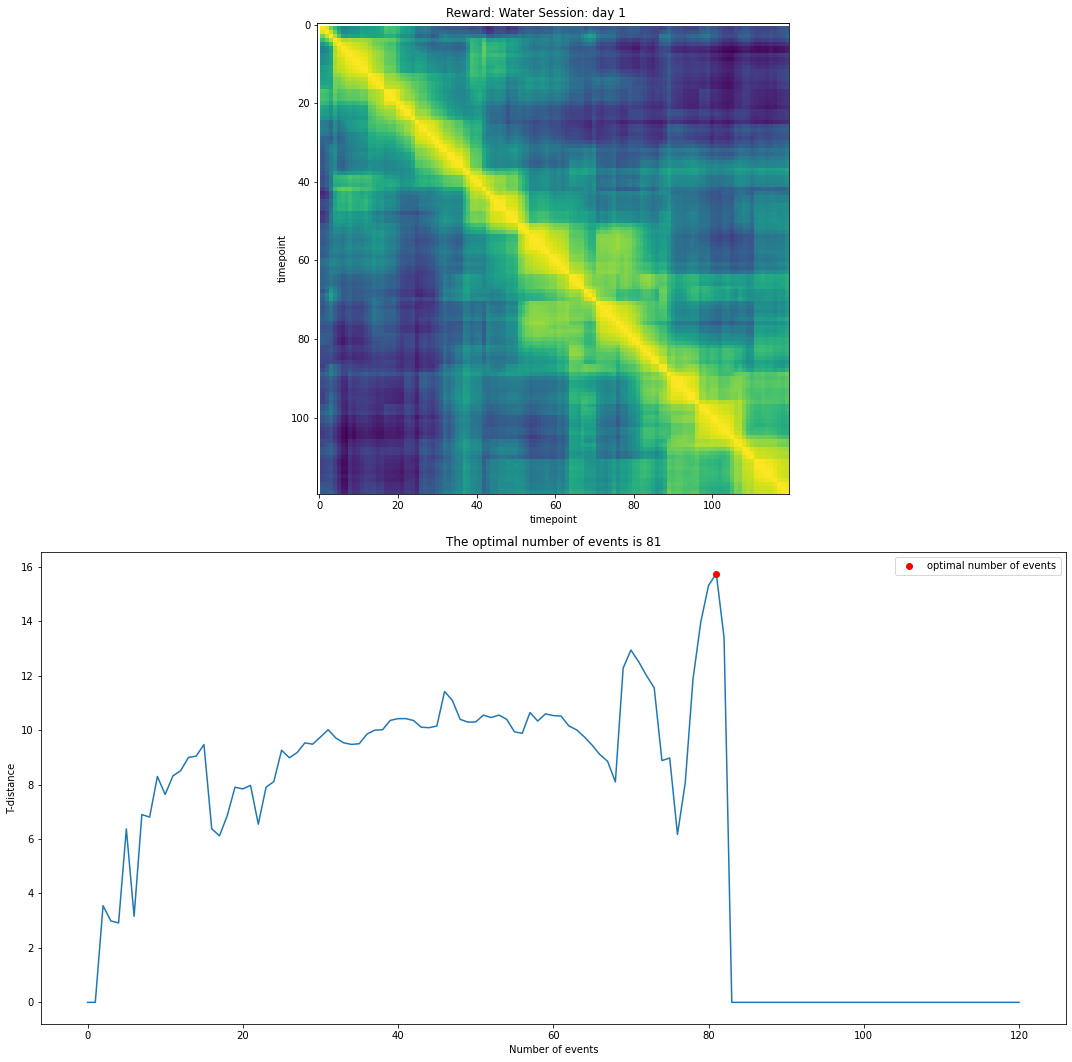

In [53]:
title_text = ""
main_title='Reward: Water Session: day 1'
plot_HMM(water1_HMM, average_corr_trial_water1, timepoints_water1, title_text, GSBS_states_water1, main_title)

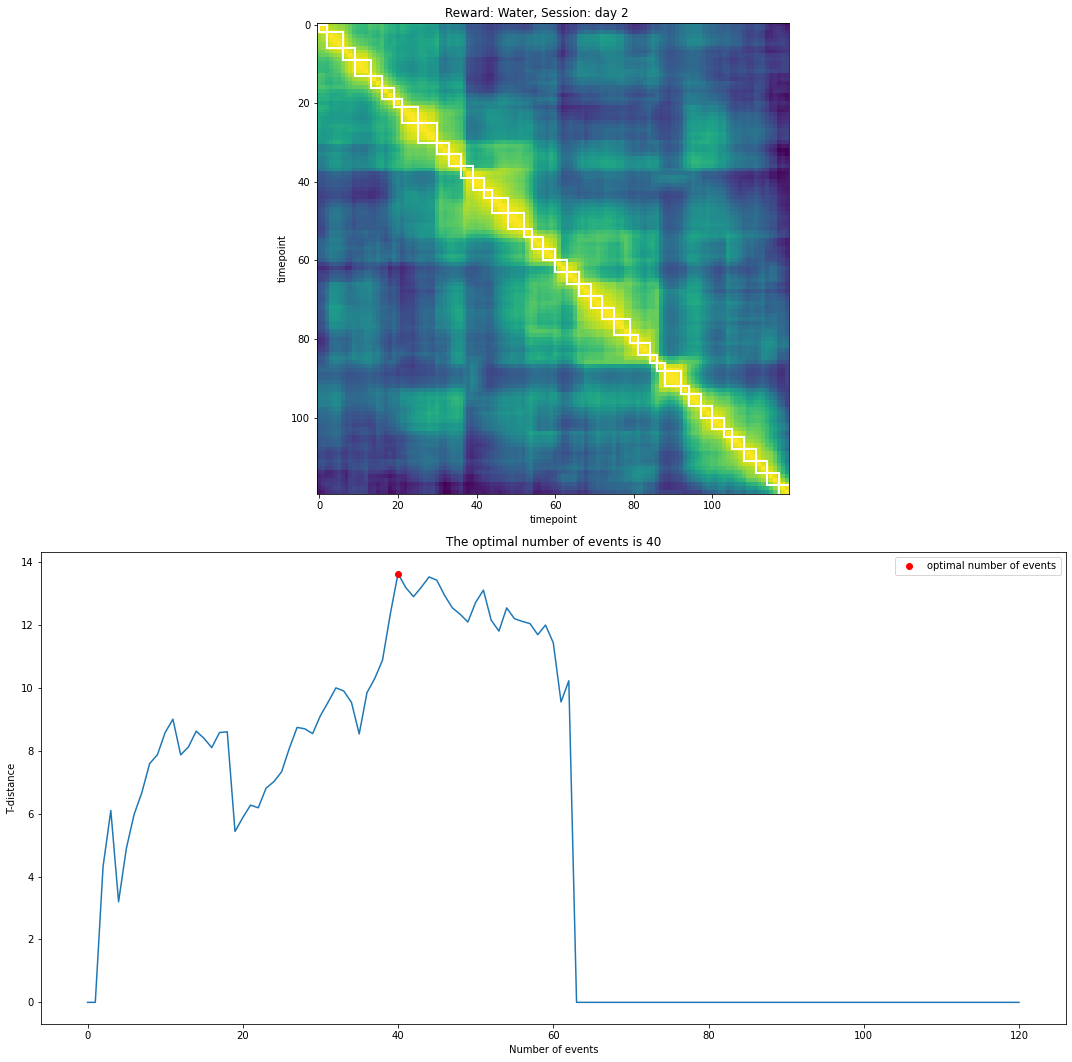

In [35]:
title_text = ""
main_title='Reward: Water, Session: day 2'
plot_HMM(water2_HMM, average_corr_trial_water2, timepoints_water2, title_text, GSBS_states_water2, main_title)

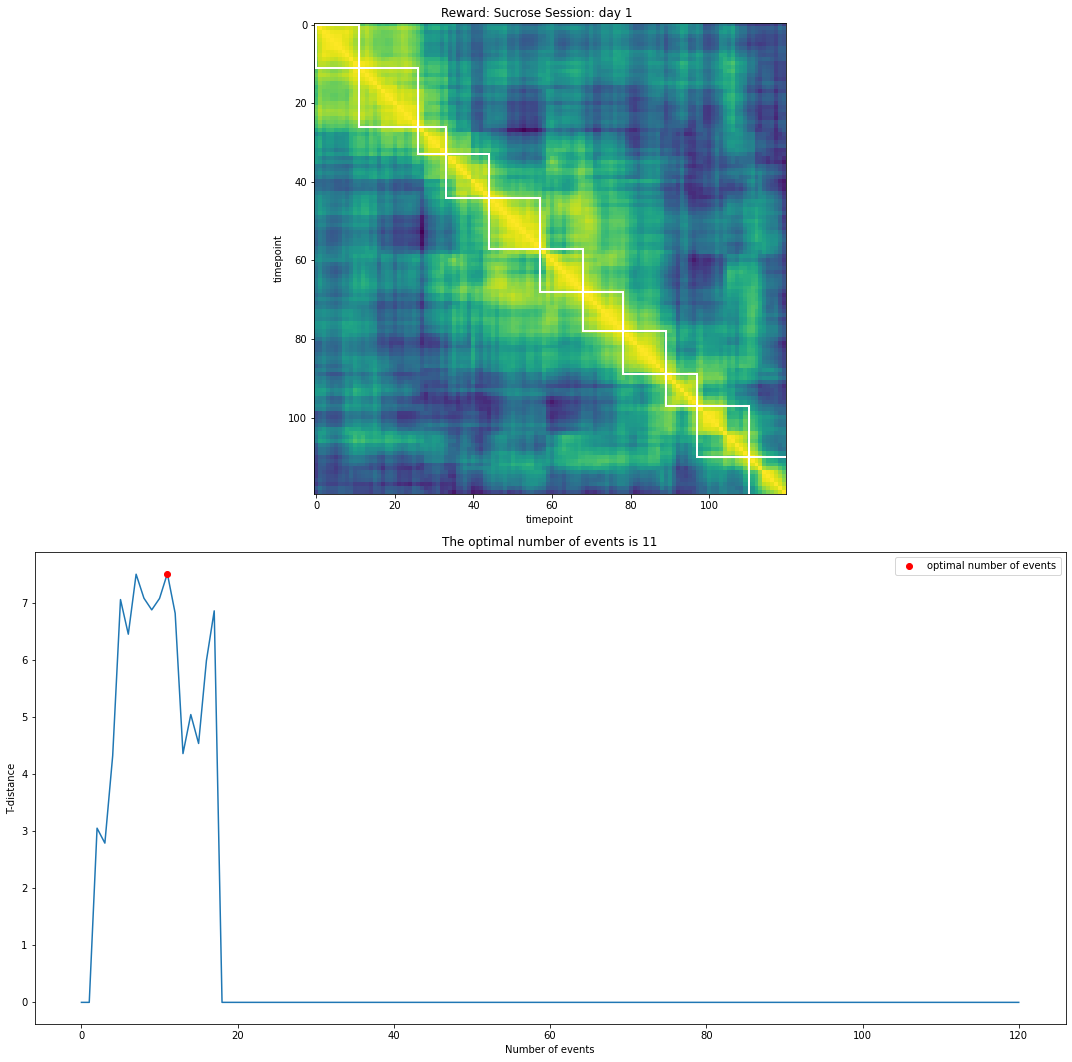

In [40]:
title_text = ""
main_title='Reward: Sucrose Session: day 1'
plot_HMM(sucrose1_HMM, average_corr_trial_sucrose1, timepoints_sucrose1, title_text, GSBS_states_sucrose1, main_title)


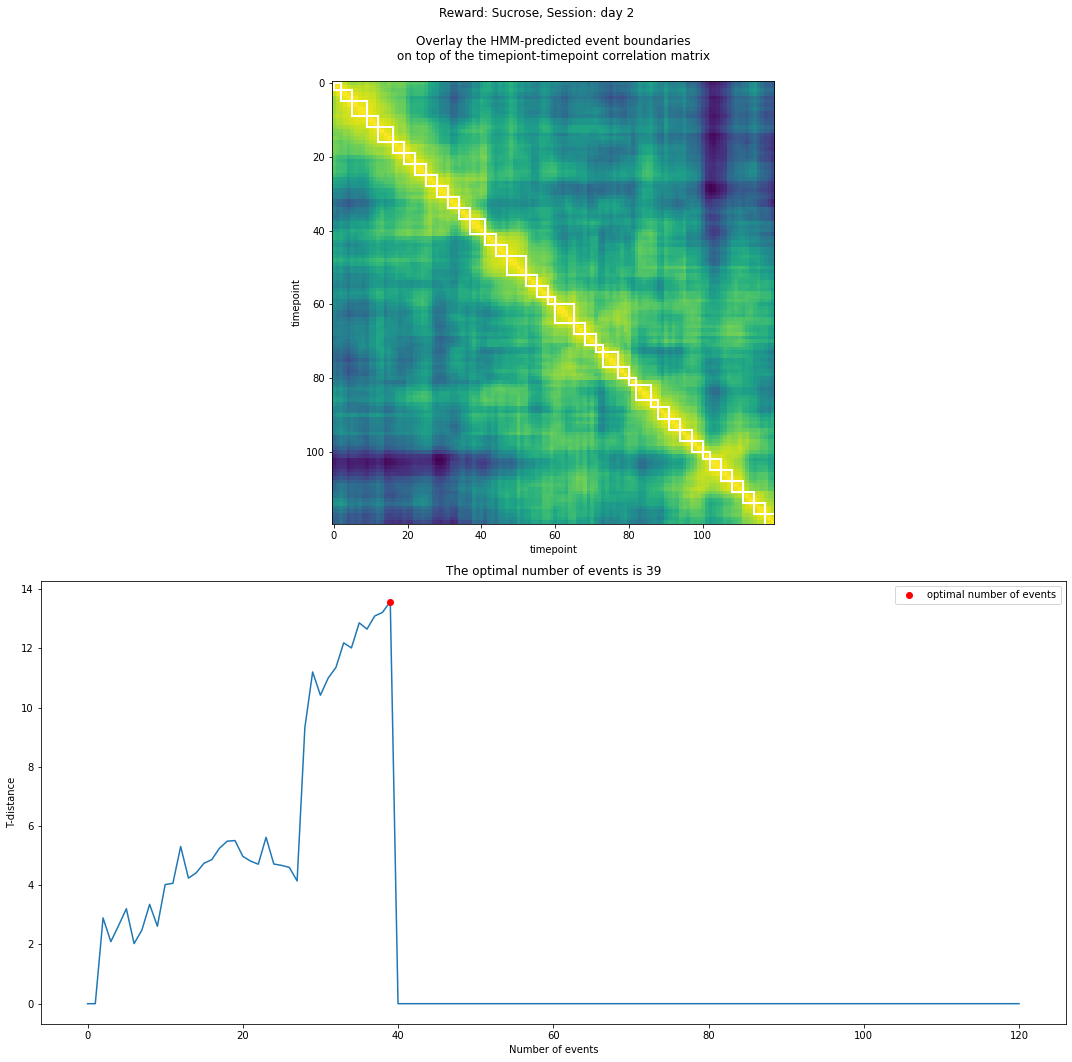

In [39]:
title_text = ""
main_title='Reward: Sucrose, Session: day 2'
plot_HMM(sucrose2_HMM, average_corr_trial_sucrose2, timepoints_sucrose2, title_text, GSBS_states_sucrose2, main_title)

